In [1]:
import numpy as np

# Set-up

## Load data

In [2]:
# Load imagenet

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging
import json


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Load the JSON file into a Python dictionary
with open(json_file_path, 'r') as file:
    num_to_word_dict = json.load(file)

# Create a reverse dictionary for word to number mapping
word_to_num_dict = {}
for num, words in num_to_word_dict.items():
    for word in words:  # Assuming each entry in num_to_word_dict is a list of words
        word_to_num_dict[word] = num

# Function to get the class name from a label
def get_class_name(label):
    # Assuming the label maps to a list of class names
    return num_to_word_dict.get(str(label), ["Unknown label"])[1]

# Function to get the label from a class name
def get_label(class_name):
    return word_to_num_dict.get(class_name, "Unknown class name")


class_name_to_lookup = "tiger_cat"  # Replace with your class name
label_from_class_name = get_label(class_name_to_lookup)
print(f"Label for class name '{class_name_to_lookup}': {label_from_class_name}")

# Transformation for the data
data_transforms = transforms.Compose([
    # Add your transformations here
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the ImageNet dataset
batch_size = 10
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)
data_loader = DataLoader(imagenet_data, batch_size=batch_size, shuffle=True)

# Get class names
imagenet_class_nums = np.arange(0, 1000, 1)
imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

Label for class name 'tiger_cat': 282


## Load model

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Text(0.5, 1.0, 'Predicted: beagle. True: Walker_hound')

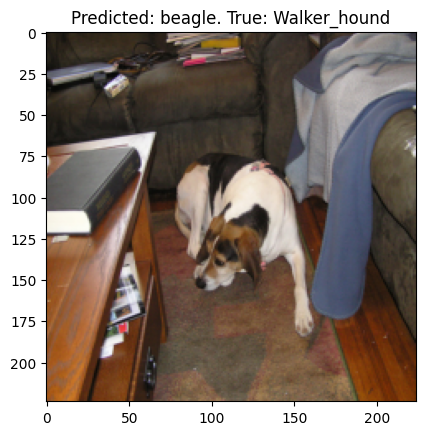

In [23]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M")
processor = CLIPProcessor.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M", do_rescale=False) # Make sure the do_rescale is false for pytorch datasets

images, labels = next(iter(data_loader))

idx = 4

inputs = processor(text=imagenet_class_names, images=images, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
# predicted_class = imagenet_class_names[probs.argmax(dim=1)]
predicted_indices = probs.argmax(dim=1)

plt.imshow(images[idx].permute(1, 2, 0))
plt.title(f"Predicted: {get_class_name(predicted_indices[idx].item())}. True: {get_class_name(labels[idx].item())}")

## Activations

In [4]:
for name, module in model.vision_model.named_parameters():
    print(name, module.shape)

embeddings.class_embedding torch.Size([256])
embeddings.patch_embedding.weight torch.Size([256, 3, 16, 16])
embeddings.position_embedding.weight torch.Size([197, 256])
pre_layrnorm.weight torch.Size([256])
pre_layrnorm.bias torch.Size([256])
encoder.layers.0.self_attn.k_proj.weight torch.Size([256, 256])
encoder.layers.0.self_attn.k_proj.bias torch.Size([256])
encoder.layers.0.self_attn.v_proj.weight torch.Size([256, 256])
encoder.layers.0.self_attn.v_proj.bias torch.Size([256])
encoder.layers.0.self_attn.q_proj.weight torch.Size([256, 256])
encoder.layers.0.self_attn.q_proj.bias torch.Size([256])
encoder.layers.0.self_attn.out_proj.weight torch.Size([256, 256])
encoder.layers.0.self_attn.out_proj.bias torch.Size([256])
encoder.layers.0.layer_norm1.weight torch.Size([256])
encoder.layers.0.layer_norm1.bias torch.Size([256])
encoder.layers.0.mlp.fc1.weight torch.Size([1024, 256])
encoder.layers.0.mlp.fc1.bias torch.Size([1024])
encoder.layers.0.mlp.fc2.weight torch.Size([256, 1024])
enc

In [5]:
activations = []
def get_activation():
    def hook(module, input, output):
        activations.append(output.detach())
    return hook

module = model.vision_model.encoder.layers[9].mlp.fc1
hook_handle = module.register_forward_hook(get_activation())
outputs = model(**inputs)
hook_handle.remove()
print(activations[0].shape)

torch.Size([10, 197, 1024])


# Visualize maximally activating neurons

In [6]:
total_images, total_labels = next(iter(data_loader))

total_images[0].shape

torch.Size([3, 224, 224])

In [10]:
# from tqdm.notebook import tqdm

# # Batch level version

# # Function to register the hook
# def register_hook(module, activations_list):
#     def hook(module, input, output):
#         activations_list.append(output.detach())
#     return module.register_forward_hook(hook)

# # Function to process images and record activations

# # Do this per batch
# def process_images(model, processor, data_loader, MAX_COUNT=None):
#     detailed_activations = []

#     count = 0

#     if MAX_COUNT is None:
#         total = len(data_loader)
#     else:
#         total = MAX_COUNT

#     for i, (images, labels) in tqdm(enumerate(data_loader), total=total):
#         activations_list.clear()

#         inputs = processor(text=imagenet_class_names, images=images, return_tensors="pt", padding=True)
#         outputs = model(**inputs)

#         logits_per_image = outputs.logits_per_image # this is the image-text similarity score
#         probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
#         predicted_class_name = [imagenet_class_names[p] for p in probs.argmax(dim=1)]

#         class_name = [get_class_name(l.item())for l in labels]
        
#         for batch_image_idx, (_, _) in enumerate(zip(images, labels)):
#             for patch_idx, patch_activations in enumerate(activations_list[0][batch_image_idx]):
#                 for neuron_idx, activation_value in enumerate(patch_activations):
#                     detailed_activations.append({
#                         'image_idx': i * len(images) + batch_image_idx,  # Correct image index for overall dataset
#                         'class_name': class_name[batch_image_idx],
#                         'predicted': predicted_class_name[batch_image_idx],
#                         'patch_idx': patch_idx,
#                         'neuron_idx': neuron_idx,
#                         'activation_value': activation_value.item()
#                     })
            
#             count += 1
#             if count >= MAX_COUNT:
#                 break

#     return detailed_activations



# global activations_list
# activations_list = []

# module = model.vision_model.encoder.layers[8].mlp.fc1 # Layer number here
# hook_handle = register_hook(module, activations_list)

# # Process images
# detailed_activations = process_images(model, processor,data_loader, MAX_COUNT=100)

# # Remove the hook when done
# hook_handle.remove()


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
from tqdm.notebook import tqdm

# Individual batch version

# Function to register the hook
def register_hook(module, activations_list):
    def hook(module, input, output):
        activations_list.append(output.detach())
    return module.register_forward_hook(hook)

# Function to process images and record activations

# Do this per batch
def process_images(model, processor, total_images, total_labels, activations_list):
    detailed_activations = []
    grouped_activations = []

    # Takes in one batch at a time,
    for i, (images, labels) in tqdm(enumerate(zip(total_images, total_labels)), total=len(total_images)):
        activations_list.clear()

        inputs = processor(text=imagenet_class_names, images=images, return_tensors="pt", padding=True)
        outputs = model(**inputs)

        class_name = get_class_name(labels.item())
        
        logits_per_image = outputs.logits_per_image # this is the image-text similarity score
        probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
        predicted_class_name = imagenet_class_names[probs.argmax(dim=1)]

        # Assuming batch size of 1 for simplicity.
        # Enumerate through patches and neurons to get each value
        for patch_idx, patch_activations in enumerate(activations_list[0][0]): # Get first batch
            for neuron_idx, activation_value in enumerate(patch_activations):
                detailed_activations.append({
                    'image_idx': i,
                    'class_name': class_name,
                    'predicted': predicted_class_name,
                    'patch_idx': patch_idx,
                    'neuron_idx': neuron_idx,
                    'activation_value': activation_value.item()
                })


    return detailed_activations

# Example usage
activations_list = []

module = model.vision_model.encoder.layers[8].mlp.fc1 # Layer number here
hook_handle = register_hook(module, activations_list)

# Process images
detailed_activations = process_images(model, processor, total_images, total_labels, activations_list)

# Remove the hook when done
hook_handle.remove()


  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
import pandas as pd

# Assume detailed_activations is filled with your data

# Convert to DataFrame
activations_df = pd.DataFrame(detailed_activations)

# Sort by max_activation_value in descending order
activations_df_sorted = activations_df.sort_values(by='activation_value', ascending=False)


In [22]:
activations_df_sorted.head(100).style.background_gradient("coolwarm")

,image_idx,class_name,predicted,patch_idx,neuron_idx,activation_value
1207901,5,schooner,schooner,194,605,4.707079
1141137,5,schooner,schooner,129,401,4.597408
507088,2,sea_cucumber,snorkel,101,208,4.512409
1199709,5,schooner,schooner,186,605,4.481476
1206877,5,schooner,schooner,193,605,4.464136
765276,3,grocery_store,grocery_store,156,348,4.389553
1197661,5,schooner,schooner,184,605,4.382064
1208925,5,schooner,schooner,195,605,4.179577
1091985,5,schooner,schooner,81,401,4.162676
1158545,5,schooner,schooner,146,401,4.126744


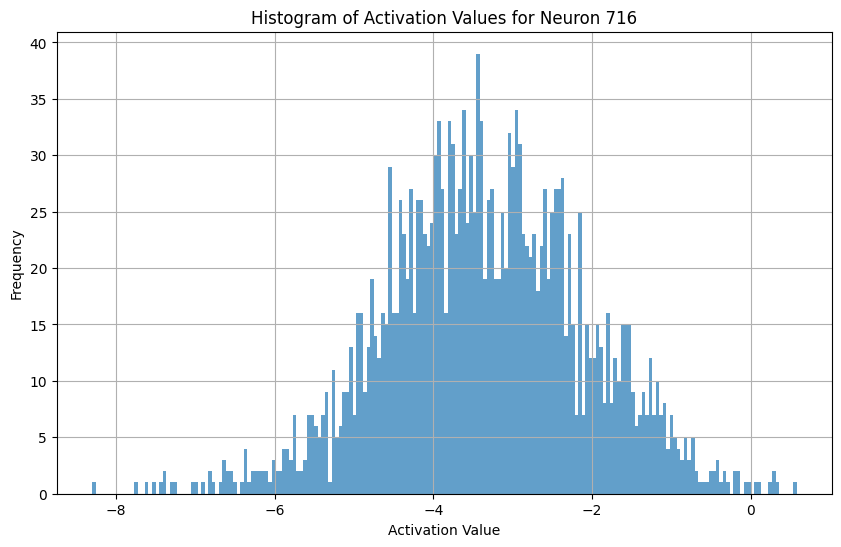

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming detailed_activations_df is your DataFrame

neuron_of_interest = 716

# Filter the DataFrame to only include the neuron of interest
filtered_df = activations_df[activations_df['neuron_idx'] == neuron_of_interest]

# Create a histogram of the activation values
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['activation_value'], bins=200, alpha=0.7)
plt.title(f'Histogram of Activation Values for Neuron {neuron_of_interest}')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [24]:
import pandas as pd

# Example values, replace with the ones you're interested in
specific_image_idx = 4 # sorrel
specific_neuron_idx = 716 # Replace X with the neuron index you're interested in

# Filter the DataFrame to only include rows for the specific image and neuron
filtered_df = activations_df[(activations_df['image_idx'] == specific_image_idx) & 
                             (activations_df['neuron_idx'] == specific_neuron_idx)]

# Now, 'filtered_df' contains all patches' activation values for the specific image and neuron

filtered_df

,image_idx,class_name,predicted,patch_idx,neuron_idx,activation_value
807628,4,nipple,pill_bottle,0,716,-1.890588
808652,4,nipple,pill_bottle,1,716,-2.335297
809676,4,nipple,pill_bottle,2,716,-3.200625
810700,4,nipple,pill_bottle,3,716,-2.856352
811724,4,nipple,pill_bottle,4,716,-2.044870
...,...,...,...,...,...,...
1004236,4,nipple,pill_bottle,192,716,-4.588823
1005260,4,nipple,pill_bottle,193,716,-4.188859
1006284,4,nipple,pill_bottle,194,716,-4.019214
1007308,4,nipple,pill_bottle,195,716,-3.589024


In [25]:
total_activation_value = filtered_df['activation_value'].sum()
total_activation_value

-672.1769639849663

In [26]:
activation_values = filtered_df['activation_value']

# Step 2: Convert to a NumPy array
activation_values_array = activation_values.to_numpy()[1:]


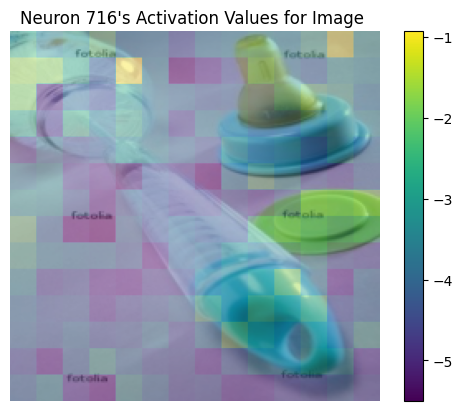

In [27]:
# Dummy data for demonstration
# Creating a dummy image of size 224x224 (typical size for a 14x14 grid of patches)
image_size = 224
dummy_image = total_images[specific_image_idx]
# Creating dummy activation values for a 14x14 grid
# Assuming the first value (CLS token) is not needed

# Reshaping the activation values to a 14x14 grid
activation_values_array = activation_values_array.reshape(14, 14)

# Create a heatmap overlay
heatmap = np.zeros((image_size, image_size))
patch_size = image_size // 14

for i in range(14):
    for j in range(14):
        heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values_array[i, j]

# Plotting the image with the heatmap overlay
fig, ax = plt.subplots()
ax.imshow(dummy_image.permute(1,2,0))
ax.imshow(heatmap, cmap='viridis', alpha=0.4)  # Overlaying the heatmap

# Removing axes
ax.axis('off')

min_activation = activation_values_array.min()
max_activation = activation_values_array.max()

# Adding colorbar for the heatmap
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_activation, vmax=max_activation)), ax=ax, orientation='vertical')

plt.title("Neuron {}'s Activation Values for Image {}".format(specific_neuron_idx, ""))
plt.show()


In [19]:
# Generate text descriptions for every patch

# save the original activations

def register_hook(module, activations_list):
    def hook(module, input, output):
        activations_list.append(output.detach())
    return module.register_forward_hook(hook)

# Function to process images and record activations
def process_images(model, image):

    inputs = processor(text=imagenet_class_names, images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)

    
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    predicted_class_name = imagenet_class_names[probs.argmax(dim=1)]


activations_list = []

module = model.vision_model.encoder.layers[8].mlp.fc1 # Layer number here
hook_handle = register_hook(module, activations_list)

process_images(model, dummy_image)

# Remove the hook when done
hook_handle.remove()

In [20]:
activations_list[0].shape

# now for every patch, feed into CLIP to get closest text. 
# You have to forward propagate to the first layer 

for patch_idx, patch_activations in enumerate(activations_list[0][0]): # Get first batch
    inputs = processor(text=imagenet_class_names, images=patch_activations, return_tensors="pt", padding=True)

    # Get feature vectors
    outputs = model(**inputs)

ValueError: Invalid image shape. Expected either 4 or 3 dimensions, but got 1 dimensions.

In [ ]:
# Aggregate across all patches for a given iamge to get maximally activating neurons

import pandas as pd

# Convert to DataFrame
activations_df = pd.DataFrame(detailed_activations)

# Group by 'image_idx' and 'neuron_idx', and sum 'activation_value'
grouped_activations = activations_df.groupby(['neuron_idx', 'image_idx', 'class_name', 'predicted'])['activation_value'].sum().reset_index()

# The result is a DataFrame with the summed activation values for each unique neuron per image


In [ ]:
grouped_activations



# For each neuron, find the image that maximally activates it

,neuron_idx,image_idx,class_name,predicted,activation_value
0,0,0,apron,hoopskirt,-271.703869
1,0,1,espresso_maker,sewing_machine,-278.501303
2,0,2,corn,centipede,-206.921735
3,0,3,fly,cicada,-280.694007
4,0,4,teddy,toy_poodle,-266.739202
...,...,...,...,...,...
102395,1023,95,corkscrew,spindle,-220.514427
102396,1023,96,German_shepherd,German_shepherd,-377.563720
102397,1023,97,leafhopper,leafhopper,-330.048245
102398,1023,98,steel_drum,drum,-159.365534


In [ ]:
import matplotlib.pyplot as plt

# Step 1: Select a Neuron
specific_neuron_idx = 716  # Replace with your specific neuron index

# Step 2: Filter Data
filtered_activations = grouped_activations[grouped_activations['neuron_idx'] == specific_neuron_idx]

# Step 3: Sort Data
sorted_activations = filtered_activations.sort_values(by='activation_value', ascending=False)

# Step 4: Plotting

# Creating labels for each bar
labels = sorted_activations.apply(lambda row: f"Pred: {row['predicted']}", axis=1)




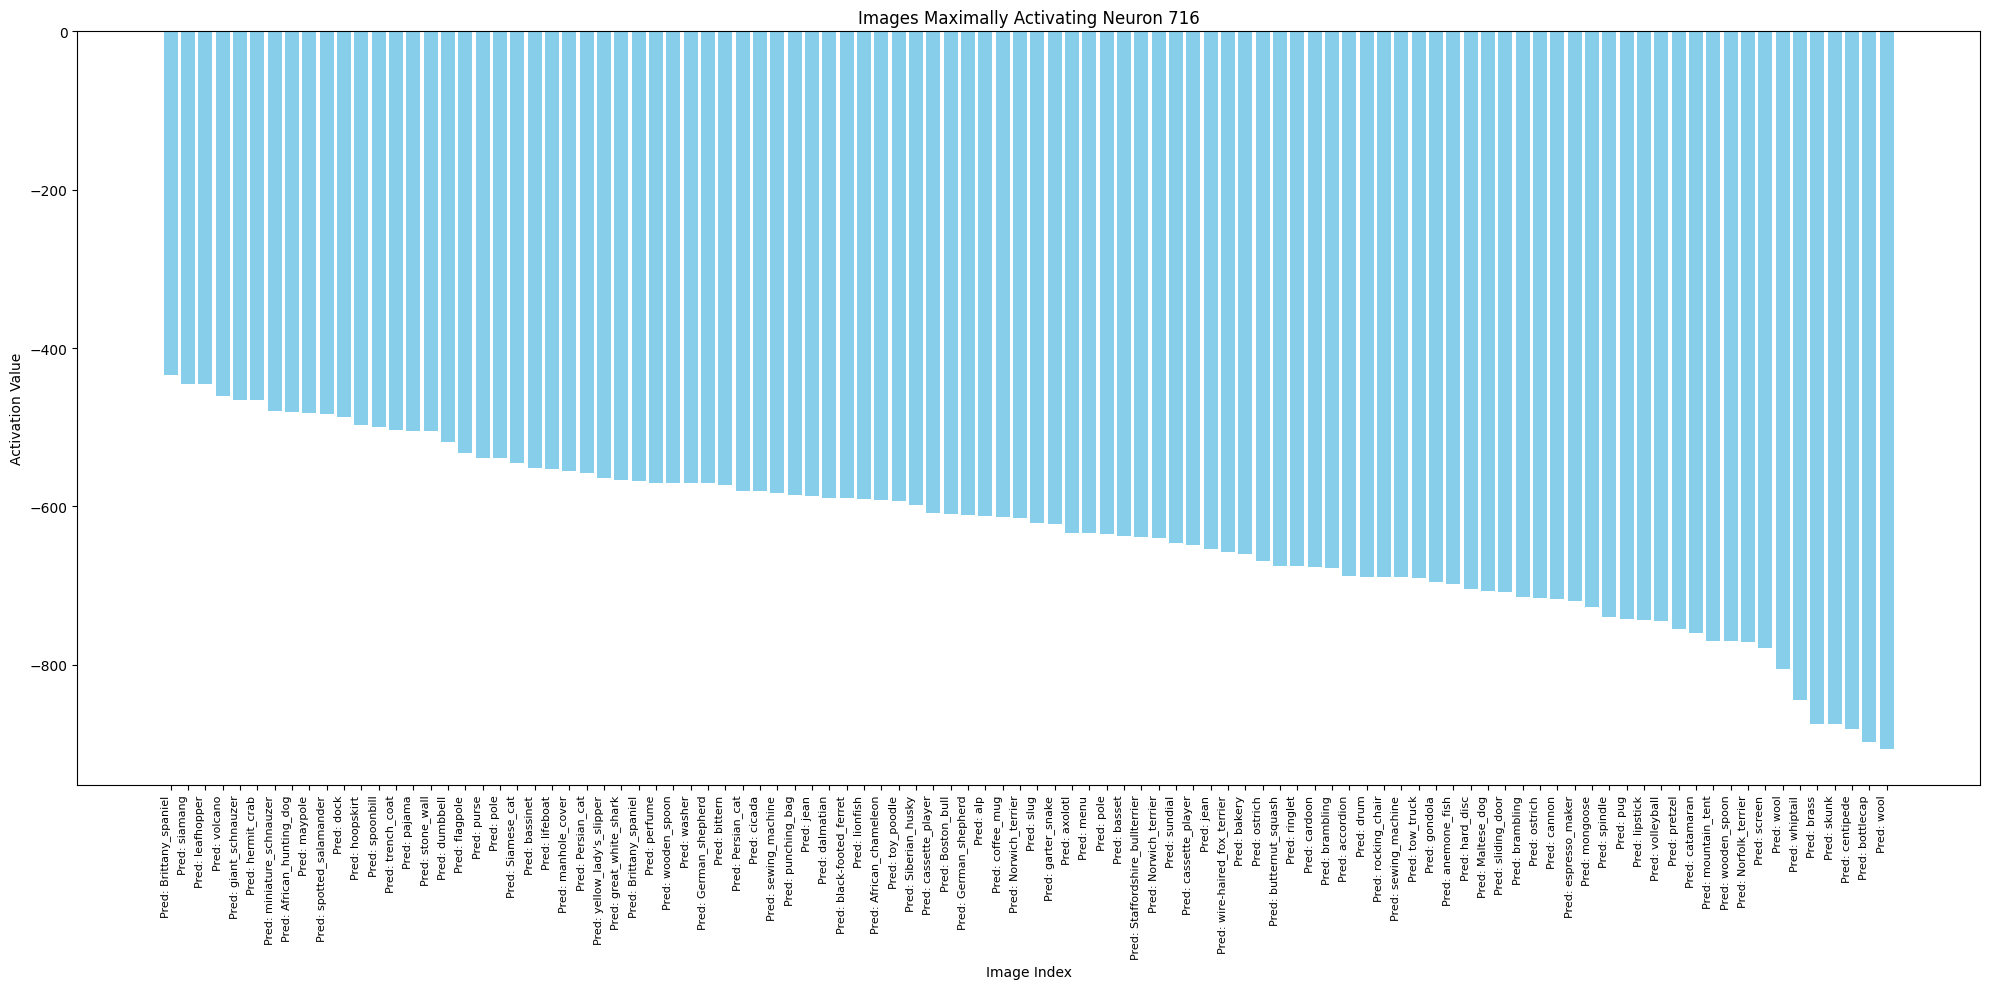

In [ ]:
# Plotting the bar graph
plt.figure(figsize=(20, 10))

plt.bar(sorted_activations['image_idx'].astype(str), sorted_activations['activation_value'], color='skyblue')

# Adding the labels
plt.xticks(sorted_activations['image_idx'].astype(str), labels, rotation=90, size=8, ha='right')

plt.xlabel('Image Index')
plt.ylabel('Activation Value')
plt.title(f'Images Maximally Activating Neuron {specific_neuron_idx}')
plt.tight_layout()
plt.show()

In [ ]:
# Go through every neuron, print top 5 most activating images

# Assuming 'grouped_activations' is the DataFrame from the previous steps

# Get unique neurons
unique_neurons = grouped_activations['neuron_idx'].unique()

# Loop through each neuron
for neuron_idx in unique_neurons:
    # Filter for the current neuron
    filtered_activations = grouped_activations[grouped_activations['neuron_idx'] == neuron_idx]

    # Sort by activation value
    sorted_activations = filtered_activations.sort_values(by='activation_value', ascending=False)

    # Get the top 5 images
    top_images = sorted_activations.head(10)
    bottom_images  = sorted_activations.tail(10)


    # Print the results
    print(f"Neuron {neuron_idx} - Top 5 Activating Images:")
    for idx, row in top_images.iterrows():
        print(f"  Image Index: {row['image_idx']}, Activation Value: {row['activation_value']}, True Class: {row['class_name']}, Predicted Class: {row['predicted']}")
    print("\n")

      # Print the results
    print(f"Neuron {neuron_idx} - Top 5 Least Activating Images:")
    for idx, row in bottom_images.iterrows():
        print(f"  Image Index: {row['image_idx']}, Activation Value: {row['activation_value']}, True Class: {row['class_name']}, Predicted Class: {row['predicted']}")
    print("\n")


Neuron 0 - Top 5 Activating Images:
  Image Index: 40, Activation Value: -35.80337514728308, True Class: wallaby, Predicted Class: mongoose
  Image Index: 63, Activation Value: -70.593606043607, True Class: little_blue_heron, Predicted Class: spoonbill
  Image Index: 92, Activation Value: -99.05100257694721, True Class: parallel_bars, Predicted Class: rocking_chair
  Image Index: 69, Activation Value: -121.57792362570763, True Class: pier, Predicted Class: dock
  Image Index: 88, Activation Value: -130.2174333035946, True Class: coffee_mug, Predicted Class: jean
  Image Index: 24, Activation Value: -141.76623190939426, True Class: sewing_machine, Predicted Class: sewing_machine
  Image Index: 45, Activation Value: -142.38706969469786, True Class: nail, Predicted Class: yellow_lady's_slipper
  Image Index: 49, Activation Value: -148.94185646995902, True Class: crane, Predicted Class: ostrich
  Image Index: 74, Activation Value: -149.1943969540298, True Class: manhole_cover, Predicted Cl

Neuron 139 - Top 5 Activating Images:
  Image Index: 62, Activation Value: 128.16992244124413, True Class: lifeboat, Predicted Class: lifeboat
  Image Index: 53, Activation Value: -137.50027959048748, True Class: tiger_shark, Predicted Class: great_white_shark
  Image Index: 72, Activation Value: -149.73544198274612, True Class: trimaran, Predicted Class: catamaran
  Image Index: 63, Activation Value: -285.8308165073395, True Class: little_blue_heron, Predicted Class: spoonbill
  Image Index: 99, Activation Value: -297.7447347044945, True Class: book_jacket, Predicted Class: hard_disc
  Image Index: 69, Activation Value: -322.1364820301533, True Class: pier, Predicted Class: dock
  Image Index: 10, Activation Value: -334.63400822877884, True Class: Boston_bull, Predicted Class: Staffordshire_bullterrier
  Image Index: 27, Activation Value: -340.5224898159504, True Class: hamper, Predicted Class: accordion
  Image Index: 16, Activation Value: -341.911524951458, True Class: ballpoint, Pr

In [ ]:
# # Can I take a patch and feed it into CLIP to get a text annotation? 

# Feed in a single patch

activations = []
def get_activation():
    def hook(module, input, output):
        activations.append(output.detach())
    return hook

module = model.vision_model.encoder.layers[8].mlp.fc1 # Layer number here

hook_handle = module.register_forward_hook(get_activation())


outputs = model(**inputs)
hook_handle.remove()
print(activations[0].shape)

patch_activations = 



inputs = processor(text=imagenet_class_names, images=patch_emb, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities


torch.Size([1, 197, 1024])


NameError: name 'patch_emb' is not defined

In [ ]:
# Process 1000 randomly sampled images from ImageNet? (Can scale this up later.)

# Save all activations to data table.
# Save the patch + image that caused that neuron to maximally activate.

# Display in table.

# Patch -- image -- class name -- neuron activation value

# Display negatively activating neurons as well.

In [ ]:
#

# 1. How do you visualize across patches // images? How did they do it for the CNN/ResNet exampel?
#

# 2. Try to get some interpretability out of these findings.  Display histogram of activation values for each neuron. Distinguish b/t per patch and per neuron.

# Package code + put in Jupyter notebook.

# Check how grad-cam method did those saliency maps on CLIP.